In [20]:
from datasets import load_dataset
from transformers import EarlyStoppingCallback, IntervalStrategy

train_ds = load_dataset("imagefolder", data_dir="data_ecs/train", split="train")


# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.3)
train_val_ds = splits['train']
test_ds = splits['test']

splits = train_val_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']


print(len(train_ds),len(test_ds),len(val_ds))

Resolving data files:   0%|          | 0/2001 [00:00<?, ?it/s]

Using custom data configuration default-53246fb818dc6894
Found cached dataset imagefolder (/home/ubuntu/.cache/huggingface/datasets/imagefolder/default-53246fb818dc6894/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


1260 600 140


In [21]:
# !pip install datasets
# !pip install Pillow
# !pip install transformers
# !pip install torch torchvision torchaudio
# !pip install -U scikit-learn
# !pip install tensorboard
# !pip install matplotlib

In [22]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 1260
})

In [23]:
import json

with open('data_ecs/label2id.json') as f:
    label2id = json.load(f)

with open('data_ecs/id2label.json') as f:
    id2label = json.load(f)

id2label = {int(key):value for key,value in id2label.items()}
id2label

{0: 'dog',
 1: 'rooster',
 2: 'pig',
 3: 'cow',
 4: 'frog',
 5: 'cat',
 6: 'hen',
 7: 'insects',
 8: 'sheep',
 9: 'crow',
 10: 'rain',
 11: 'sea_waves',
 12: 'crackling_fire',
 13: 'crickets',
 14: 'chirping_birds',
 15: 'water_drops',
 16: 'wind',
 17: 'pouring_water',
 18: 'toilet_flush',
 19: 'thunderstorm',
 20: 'crying_baby',
 21: 'sneezing',
 22: 'clapping',
 23: 'breathing',
 24: 'coughing',
 25: 'footsteps',
 26: 'laughing',
 27: 'brushing_teeth',
 28: 'snoring',
 29: 'drinking_sipping',
 30: 'door_wood_knock',
 31: 'mouse_click',
 32: 'keyboard_typing',
 33: 'door_wood_creaks',
 34: 'can_opening',
 35: 'washing_machine',
 36: 'vacuum_cleaner',
 37: 'clock_alarm',
 38: 'clock_tick',
 39: 'glass_breaking',
 40: 'helicopter',
 41: 'chainsaw',
 42: 'siren',
 43: 'car_horn',
 44: 'engine',
 45: 'train',
 46: 'church_bells',
 47: 'airplane',
 48: 'fireworks',
 49: 'hand_saw'}

In [24]:

from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


loading configuration file preprocessor_config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/preprocessor_config.json
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [25]:
feature_extractor.size

{'height': 224, 'width': 224}

In [26]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(224),
            CenterCrop(224),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [27]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [28]:
val_ds[:2]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369>],
 'classID': [27, 13],
 'class': ['brushing_teeth', 'crickets'],
 'pixel_values': [tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [ 0.9451,  0.9686,  0.9765,  ...,  0.9608,  0.9373,  0.9216],
           [ 0.9686,  0.9843,  0.9843,  ...,  0.9765,  0.9529,  0.9373],
           [ 0.9765,  0.9843,  0.9843,  ...,  0.9843,  0.9529,  0.9373]],
  
          [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [-0.0824,  0.0275,  0.0902,  ...,  0.0118, -0.1059, -0.1686],
           [

In [29]:

from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["classID"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [30]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [31]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=50,
                                                  id2label=id2label,
                                                  label2id=label2id)

loading configuration file config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "dog",
    "1": "rooster",
    "2": "pig",
    "3": "cow",
    "4": "frog",
    "5": "cat",
    "6": "hen",
    "7": "insects",
    "8": "sheep",
    "9": "crow",
    "10": "rain",
    "11": "sea_waves",
    "12": "crackling_fire",
    "13": "crickets",
    "14": "chirping_birds",
    "15": "water_drops",
    "16": "wind",
    "17": "pouring_water",
    "18": "toilet_flush",
    "19": "thunderstorm",
    "20": "crying_baby",
    "21": "sneezing",
    "22": "clapping",
    "23": "breathing",
    "24": "coughing",
 

In [32]:
from transformers import file_utils
print(file_utils.default_cache_path)

/home/ubuntu/.cache/huggingface/hub


In [33]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-ecs50-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [34]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Using the latest cached version of the module from /home/ubuntu/.cache/huggingface/modules/datasets_modules/metrics/accuracy/9756d5fa4a0f9da966341741fc3926eafdc604b8276add51d5abbaa8958a25f9 (last modified on Mon Dec  5 08:03:28 2022) since it couldn't be found locally at accuracy, or remotely on the Hugging Face Hub.


In [35]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

In [36]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 1260
})

In [37]:

# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [38]:
trainer.train()

/home/ubuntu/mlenv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1260
  Num Epochs = 50
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 6300
  Number of trainable parameters = 85837106


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.658437,0.271429
2,No log,3.381681,0.407143
3,No log,3.165191,0.407143
4,3.421400,2.951771,0.485714
5,3.421400,2.791856,0.542857
6,3.421400,2.640490,0.571429
7,3.421400,2.510593,0.614286
8,2.630100,2.390392,0.614286
9,2.630100,2.305790,0.642857
10,2.630100,2.174632,0.678571


***** Running Evaluation *****
  Num examples = 140
  Batch size = 4
Saving model checkpoint to test-ecs50-10/checkpoint-126
Configuration saved in test-ecs50-10/checkpoint-126/config.json
Model weights saved in test-ecs50-10/checkpoint-126/pytorch_model.bin
Image processor saved in test-ecs50-10/checkpoint-126/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 140
  Batch size = 4
Saving model checkpoint to test-ecs50-10/checkpoint-252
Configuration saved in test-ecs50-10/checkpoint-252/config.json
Model weights saved in test-ecs50-10/checkpoint-252/pytorch_model.bin
Image processor saved in test-ecs50-10/checkpoint-252/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 140
  Batch size = 4
Saving model checkpoint to test-ecs50-10/checkpoint-378
Configuration saved in test-ecs50-10/checkpoint-378/config.json
Model weights saved in test-ecs50-10/checkpoint-378/pytorch_model.bin
Image processor saved in test-ecs50-10/checkpoint-378/preprocesso

  Num examples = 140
  Batch size = 4
Saving model checkpoint to test-ecs50-10/checkpoint-3150
Configuration saved in test-ecs50-10/checkpoint-3150/config.json
Model weights saved in test-ecs50-10/checkpoint-3150/pytorch_model.bin
Image processor saved in test-ecs50-10/checkpoint-3150/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 140
  Batch size = 4
Saving model checkpoint to test-ecs50-10/checkpoint-3276
Configuration saved in test-ecs50-10/checkpoint-3276/config.json
Model weights saved in test-ecs50-10/checkpoint-3276/pytorch_model.bin
Image processor saved in test-ecs50-10/checkpoint-3276/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from test-ecs50-10/checkpoint-2646 (score: 0.8285714285714286).


TrainOutput(global_step=3276, training_loss=2.010805169595758, metrics={'train_runtime': 1516.5309, 'train_samples_per_second': 41.542, 'train_steps_per_second': 4.154, 'total_flos': 2.53972972404523e+18, 'train_loss': 2.010805169595758, 'epoch': 26.0})

In [39]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 600
  Batch size = 4


In [40]:
print(outputs.metrics)

{'test_loss': 1.3706001043319702, 'test_accuracy': 0.805, 'test_runtime': 10.1897, 'test_samples_per_second': 58.883, 'test_steps_per_second': 14.721}


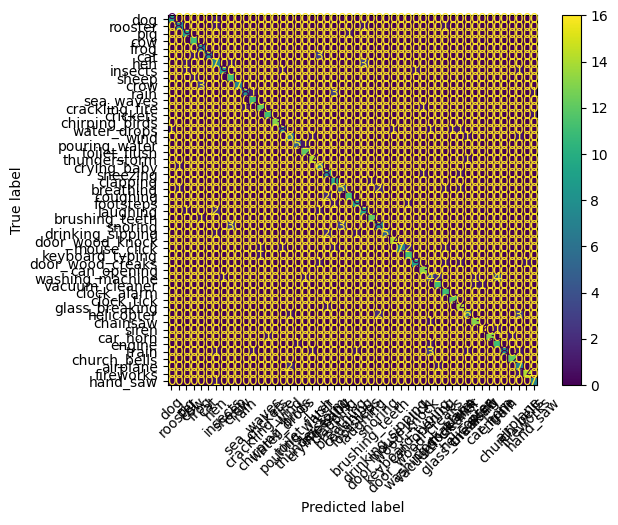

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = id2label.values()
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [42]:
model.save_pretrained("/home/ubuntu/models/AudioViT_ECS50")

Configuration saved in /home/ubuntu/models/AudioViT_ECS50/config.json
Model weights saved in /home/ubuntu/models/AudioViT_ECS50/pytorch_model.bin
